In [1]:
import warnings
warnings.simplefilter('ignore')
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import matplotlib
import matplotlib.pyplot as plt
import joblib
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, LSTM
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras import losses
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
import copy

# Часть 7. Задача регрессии. Определение изменения цены HIGH в течении часа

Загружаем сформированный в части 6 датасет с таргетом в виде изменения цены HIGH в течении часа:

In [2]:
marked_dataset = joblib.load('marked_dataset_for_regression_with_high_average_delta.pkl')

In [3]:
marked_dataset.shape

(20045, 97)

Мы видим размерность данных - `(20045, 97)`. Более чем достаточно для обучения нейронной сети.
Будем применять ***тип слоев нейронной сети GRU (tensorflow.keras.layers.GRU)***. Соответственно, нам потребуется применить обратный порядок столбцов/признаков, так как сеть GRU предназначена для анализа временных рядов и первыми должны подаваться на вход признаки с более ранней хронологией. Для этого пишем функцию перестановки столбцов:

In [4]:
def reverse_order_of_columns(marked_dataset):
    new_order = list(range(95, -1, -1))
    new_order = new_order + [96]
    dataset = marked_dataset[marked_dataset.columns[new_order]]
    return dataset

In [5]:
marked_dataset = reverse_order_of_columns(marked_dataset)

Применяем стандартные процедуры шкалирования данных и определения тренировочной и тестовой выборок:

In [6]:
scaler = StandardScaler()
X = marked_dataset.drop(columns='class')
X_train = scaler.fit_transform(X)

Y = marked_dataset['class']
y_train = Y.values

In [7]:
X_train, X_test = X_train[:15000], X_train[15000:18000]
y_train, y_test = y_train[:15000], y_train[15000:18000]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15000, 96), (3000, 96), (15000,), (3000,))

Здесь конечно важно упомянуть следующее. Хоть мы и применили название "тестовая выборка", и с точки зрения хронологии это данные, отстоящие после тренировочной выборки, по сути эти данные являются ***валидационной выборкой***. В настоящем понимании тестовые данные будут применяться только после выбора окончательной модели, и перед запуском модели в продакшн (то есть в реальную биржевую торговлю). Это отдельная процедура, здесь не рассматриваемая. Для наших задач определения топологии и типа датасета, способов работы с индексом SP&500 валидационной выборки вполне достаточно.

Конечно же, для валидационной выборки желательно применить также период, состоящий из периода падающего рынка, или же рынка во флэте. Далее этот вопрос будет рассмотрен.

Продолжаем процесс преобразования данных. Меняем размерность данных, чтобы данные поступали в нейронную сеть GRU порциями `3 * 32` - для того, чтобы сеть могла установить временную зависимость между каждым часом. Посмотрим, как это у нее получится.

In [8]:
X_train = X_train.reshape(X_train.shape[0], 32, 3)
X_test = X_test.reshape(X_test.shape[0], 32, 3)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15000, 32, 3), (3000, 32, 3), (15000,), (3000,))

Инициализируем сеть и запускаем процесс обучения:

In [9]:
model = Sequential()
model.add(layers.GRU(12, input_shape=(None, X_train.shape[-1])))

model.add(layers.Dense(10, activation='relu'))

model.add(layers.Dense(1, activation='linear'))

model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mean_squared_error')

model.fit(X_train, y_train, epochs=80, batch_size=60, use_multiprocessing=True,
         verbose=0, validation_data=(X_test, y_test))

Модель обучилась. Но что означает ***`loss='mean_squared_error`' в районе 14-15***? Так сразу не понять.
Поэтому приступим к ***визуальной проверке точности*** обученной модели на тестовом датасете. Сформируем для удобства анализа и применения фильтров датафрейм, состоящий из тестовых данных и данных, выданных моделью:

In [10]:
y_pred = model.predict(X_test)
y_pred = [y_pred[i][0] for i in range(len(y_pred))]
df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
len(df)

3000

Выборочно визуализируем моменты данных при номере индекса `k = 1890, 150, 1790, 1840, 90`. Синим цветом отобразим тестовые данные, красным - данные, выданные моделью. Например, так выглядят данные при `k=90`:

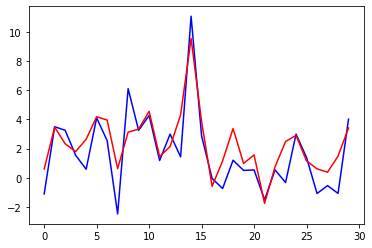

In [15]:
#k=1890, 150, 1790, 1840, 90
k=90
plt.plot(range(30), df.y_test[k:k+30], color='blue')
plt.plot(range(30), df.y_pred[k:k+30], color='red')

Сразу бросается в глаза, что особенно хорошо модель "видит" будущее изменение цены, если это изменение относительно велико. В принципе, это то, что нам как раз и нужно: прибыль от волатильных сделок намного выше.

С учетом этого конкретизируем запрос к модели. Если модель выдает изменение цены более чем на 5 пунктов, то каково соотношение между сделками с действительным ростом более чем на 5 пунктов и числом сделок, в которых цена упала ниже нуля относительно текущего среднего уровня?

In [38]:
res_pos = df[(df.y_pred>5)&(df.y_test>5)]
res_neg = df[(df.y_pred>5)&(df.y_test<0)]
len(res_pos) / (len(res_pos) + len(res_neg))

0.933920704845815

In [39]:
len(res_pos)

424

Как видим, в 93% случаев модель выдала нам надежные рекомендации об увеличении цены более чем на 5 пунктов, и лишь в 7% цена упала ниже среднего уровня. ***Напоминаю, что речь идет о валидационных данных***, что служит хорошим предвестником проведения ***всестороннего бэктеста*** в рамках рассмотренной концепции формирования датасета и его обучения.

И просто для наглядности примера отберем первые 20 моментов, когда модель выдала изменение цены более чем на 5 пунктов:

In [40]:
df[(df.y_pred>5)][:20]

,y_test,y_pred
7,1.600,5.450651
8,5.175,5.186965
9,1.745,5.286045
14,5.905,13.153670
17,2.825,5.179898
21,14.990,9.813053
22,6.350,7.401930
35,5.265,9.549406
41,1.985,5.031772
48,2.275,5.225728


# Часть 8. Пример работы с ситуативно-управляемым отбором

Рассмотренный выше удачный кейс на валидационных данных с применением фильтров по волатильности рекомендаций (уже после обучения модели на общих данных), ставит перед нами следующий очевидный вопрос: надо ли попробовать избавить первоначальный датасет от шума данных? То есть тех моментов, которые, выражаясь простым языком, "ни туда ни сюда".

Действительно. Ведь если период неопределенности на рынке тянется много часов подряд, не выдает нам четких рекомендаций с точки зрения количества позиций Лонг или Шорт, почему мы должны загружать эти данные в модель МО? Это лишняя нагрузка для модели, оттягивающая на себя все весовые коэффициенты нейронной сети и не оставляющая сети возможности сосредоточиться на каких-то точечных моментах с нужной нам высокой волатильностью, допустим.

Загрузим первоначальные данные:

In [13]:
marked_dataset = joblib.load('marked_dataset_for_regression_with_high_average_delta.pkl')
marked_dataset = reverse_order_of_columns(marked_dataset)

И уже применим фильтр для отбора часов - строк датасета, когда ситуация, с нашей экспертной точки зрения, действительно предполагает весьма высокую волатильность в следующем часе. В нашем случае: давление моментов `Low` текущего часа более 25, или давление моментов `High` более 25. Таким образом мы точечно подходим к данным, избегая сплошной выбор данных и многочисленные ситуации неопределенности. По идее, сеть должна обучиться гораздо лучше, так как ей не будут мешать эти неопределенные моменты. Такой подход именуется ***ситуативно-управляемым отбором***.

In [92]:
md = marked_dataset[(marked_dataset['0_lowes3']>25)|(marked_dataset['0_highes3']>25)]
len(md)

12276

Есть и обратная сторона такого отбора. Размер датасета упал с 20 тысяч до 12 тысяч. Такая ситуация в некоторых случаях может характеризоваться нехваткой данных для обучения. Но вроде бы данных пока достаточно, с нашей точки зрения.

Повторяем весь процесс преобразования данных и обучения модели:

In [93]:
scaler = StandardScaler()
X = md.drop(columns='class')
X_train = scaler.fit_transform(X)

Y = md['class']
y_train = Y.values

In [94]:
border = int(len(md)//1.3)
border

9443

In [95]:
X_train, X_test = X_train[:border], X_train[border:]
y_train, y_test = y_train[:border], y_train[border:]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9443, 96), (2833, 96), (9443,), (2833,))

In [96]:
X_train = X_train.reshape(X_train.shape[0], 32, 3)
X_test = X_test.reshape(X_test.shape[0], 32, 3)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9443, 32, 3), (2833, 32, 3), (9443,), (2833,))

In [ ]:
model = Sequential()
model.add(layers.GRU(8, input_shape=(None, X_train.shape[-1])))

model.add(layers.Dense(6, activation='relu'))

model.add(layers.Dense(1, activation='linear'))

model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mean_squared_error')



model.fit(X_train, y_train, epochs=80, batch_size=40, use_multiprocessing=True,
         verbose=0, validation_data=(X_test, y_test))

In [98]:
y_pred = model.predict(X_test)

In [99]:
y_pred = [y_pred[i][0] for i in range(len(y_pred))]
df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
len(df)

2833

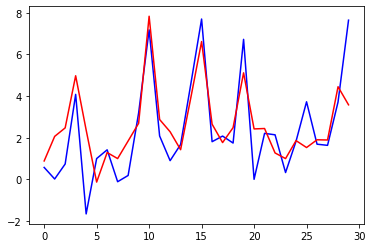

In [101]:
#k=890, 150, 790, 840, 1150
k=890
plt.plot(range(30), df.y_test[k:k+30], color='blue')
plt.plot(range(30), df.y_pred[k:k+30], color='red')

Пока что наши рассуждения верны. Сеть действительно начинает уделять большее внимание волатильным моментам.

# Часть 9. Задача классификации. Реализация тройного барьерного метода, с учетом волатильности в момент входа в сделку

Отвлечемся от задачи регрессии, то есть определения изменения цены в следующем часе относительно текущего. Ведь на практике мы как активные инвесторы определяем норму взятия прибыли (т.н. тейкпрофит) и норму остановки убытка (т.н. стоплосс). Или же оставляем позицию открытой, в рамках определенного временного окна.

Подобная ситуация в рамках машинного обучения моделируется как задача классификации, с 3-мя классами.

#### Пример описательного моделирования

Допустим, мы хотим фиксировать прибыль при достижении нормы прибыли 2% (то есть уровень тейкпрофит). Если не удается, фиксируем убытки на уровне стоплосс тоже 2%, зеркально. Также действует временное окно для нашей позиции - 30 часов.
Начальные параметры нашего поведения заданы.

Последовательность наших действий для маркировки таргета в виде задачи классификации видится следующим образом.
Для каждого часа берем цену ***`Price=(Price_high+Price_low)/2`***. Идем вдоль временного ряда и отслеживаем, какое из событий в течение временного окна (то есть за 30 часов) случится первым:

- `Price_high/Price > 1.02` (***маркируем текущий час как "2" - тейкпрофит***, то есть рекомендуется открывать позицию Лонг в расчете на рост рынка более чем на 2%)

или же

- `Price_low/Price < 0.98` (***маркируем текущий час как "0" - стоплосс***, то есть рекомендуется открывать позицию Шорт в расчете на падение рынка более чем на 2%)

Если ни одно из этих событий за 30 часов не произошло, считаем, что ничего не делаем, и
- (***маркируем текущий час как "1" - холд***)

Напоминаю, что маркировка 2,1,0 - условная, предназначена для задачи классификации в рамках машинного обучения.

Описанная методика классификации путем установления ограничений для цены сверху (тейкпрофит), снизу (стоплосс) и впереди движения цены (размер временного окна) называется ***тройным барьерным методом***. Действительно, какой-то из этих барьеров обязательно сработает.

#### Вспоминаем роль волатильности

Ок, с методологией маркировки таргета все понятно. Но какие нормы тейкпрофит и стоплосс следует взять? И должны ли они быть равны? Расширим вопрос. Должны ли эти нормы сохраняться на протяжении всего временного ряда?

Имеет смысл опереться на волатильность. Рассмотренная задача регресии убедила нас, что волатильность - важнейший фактор. И мы можем фиксировать прибыли и убытки на уровне низкого тейкпрофит в периоды низкой волатильности, и увеличивать эти нормы в периоды высокой волатильности.

Соответственно, будем рассматривать задачу классификации еще шире. Мы будем брать разные уровни тейкпрофит и стоплосс в зависимости от текущей волатильности, помноженные на соответствующие коэффициенты. Волатильность, в свою очередь, тоже может рассчитываться за разные периоды времени.

Итак, нам нужно определить наилучшие коэффициенты для тейкпрофит, стоплосс, наилучший период для определения волатильности. Временное окно удержания позиции приравняем к 20.

Критерием выбора наилучших коэффициентов будет наилучшая ***матрица неточностей `confusion matrix` из sklearn***. Инструментом быстрого отбора лучших результатов будет служить ***`f1_score`*** из той же библиотеки.

Нижеприведенный код реализует вышеописанную логику.

#### Подготовка данных и функций для итеративного отбора наилучших параметров тейкпрофит, стоплосс, периода волатильности

In [19]:
marked_dataset = joblib.load('marked_dataset_for_regression_with_high_average_delta.pkl')

marked_dataset = reverse_order_of_columns(marked_dataset)

In [20]:
scaler = StandardScaler()
X = marked_dataset.drop(columns='class')
X_train = scaler.fit_transform(X)
X_train, X_test = X_train[:15000], X_train[17150:18000]

X_train = X_train.reshape(X_train.shape[0], 32, 3)
X_test = X_test.reshape(X_test.shape[0], 32, 3)
X_train.shape, X_test.shape

((15000, 32, 3), (850, 32, 3))

> Обратим внимание, что периодом тестовой (валидационной) выборки выбран период неустойчивого флэта на рынке, скорее даже падение рынка во второй половине выборки. Это можно проследить по индексам периода выборки (до шкалирования), при желании.

> Это сделано с целью предотвращения выбора переобученной модели, так как модель с 2008г. по 2017г. обучается на периоде, в котором рынок растет.

In [21]:
SP = joblib.load('SP.pkl')
temp_dataset = pd.DataFrame(index=marked_dataset.index)
temp_dataset['Price_high'] = SP['Price_high']
temp_dataset['Price_low'] = SP['Price_low']
temp_dataset['Price'] = SP['Price']

In [22]:
# функция для получения таргет-столбца, маркированного 2,1,0
def get_class_dat(temp_dataset, window=15, timelen=40, profitcoef=2,
                  losscoef=2, fix_volat=False):
    Price_high = list(temp_dataset['Price_high'])
    Price_low = list(temp_dataset['Price_low'])
    Price = list(temp_dataset['Price'])
    Target_class = [1] * len(Price)
    volat = list(temp_dataset['Price_high'].rolling(window=window,
                                                    min_periods=1).std())
    volat[0] = volat[1]
    
    for i in range(len(Price)-timelen):
        price = Price[i]
        if fix_volat:
            takeprofit =  1 + (profitcoef / 100)
            stoploss = 1 - (losscoef / 100)
        else:
            takeprofit =  1 + (volat[i] / price * profitcoef)
            stoploss = 1 - (volat[i] / price * losscoef)            
        for y in range(i+1, i+1+timelen):
            delta_high = Price_high[y] / price
            delta_low = Price_low[y] / price
            if delta_high > takeprofit:
                Target_class[i] = 2
                break
            if delta_low < stoploss:
                Target_class[i] = 0
                break
    classification_dataset = temp_dataset.copy(deep=True)
    classification_dataset['class'] = Target_class

    return classification_dataset['class']

In [23]:
# функция проведения обучения нейронной сети и получения
# выданных обученной моделью результатов на тестовых данных
def get_nn_testings(X_train, y_train, X_test, y_test):
    model = Sequential()
    model.add(layers.GRU(12, input_shape=(None, X_train.shape[-1])))

    model.add(layers.Dense(10, activation='relu'))

    model.add(layers.Dense(3, activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=60, batch_size=40, use_multiprocessing=True,
             verbose=0, validation_data=(X_test, y_test))
    y_pred = model.predict(X_test)
    y_pred = [np.argmax(i) for i in y_pred]
    
    return y_pred

#### Задаем пространство поиска параметров

In [24]:
profitcoef_s = [1,3]
losscoef_s = [1,3]
windows = [5,15,40]

#### Итерации с игнорированием волатильности `(fix_volat=True)`

In [ ]:
results = []
for profitcoef in profitcoef_s:
    for losscoef in losscoef_s:
        for window in windows:
            Y = get_class_dat(temp_dataset, window=window, timelen=20,
                              profitcoef=profitcoef, losscoef=losscoef,
                              fix_volat=True)
            y_train = Y.values
            y_train, y_test = y_train[:15000], y_train[17150:18000]
            y_pred = get_nn_testings(X_train, y_train, X_test, y_test)
            print('---------------------------')
            print('confusion_matrix = ')
            print(confusion_matrix(y_test, y_pred))
            print('f1 = ', f1_score(y_test, y_pred, average='micro'))
            print('profitcoef, losscoef, window = ', profitcoef, losscoef, window)
            
            results.append([f1_score(y_test, y_pred, average='micro'),
                            profitcoef, losscoef, window])

#### Итерации с учетом волатильности `(fix_volat=False)`

In [51]:
results_2 = []
for profitcoef in profitcoef_s:
    for losscoef in losscoef_s:
        for window in windows:
            Y = get_class_dat(temp_dataset, window=window, timelen=20,
                              profitcoef=profitcoef, losscoef=losscoef,
                              fix_volat=False)
            y_train = Y.values
            y_train, y_test = y_train[:15000], y_train[17150:18000]
            y_pred = get_nn_testings(X_train, y_train, X_test, y_test)
            print('---------------------------')
            print('confusion_matrix = ')
            print(confusion_matrix(y_test, y_pred))
            print('f1 = ', f1_score(y_test, y_pred, average='micro'))
            print('profitcoef, losscoef, window = ', profitcoef, losscoef, window)
            
            results_2.append([f1_score(y_test, y_pred, average='micro'),
                            profitcoef, losscoef, window])

---------------------------
confusion_matrix = 
[[210   0 117]
 [  0   0   1]
 [ 98   0 424]]
f1 =  0.7458823529411764
profitcoef, losscoef, window =  1 1 5


Итак, наилучшие результаты получены при параметрах с учетом волатильности `(fix_volat=False)`, и набором `profitcoef, losscoef, window =  1, 1, 5`. Причем эти результаты сильно лучше по сравнению с моделями без учета волатильности. Получается, ***динамическая во времени тактика взятия прибылей и фиксации убытков доказывает свою эффективность***, что мы и выяснили эмпирическим путем.

К последней рассмотренной модели с динамической классификацией теперь необходимо применить вышерассмотренный ситуативно-управляемый отбор. Почему необходимо? Хотя бы потому, что в коде тейкпрофит определен как `takeprofit =  1 + (volat[i] / price * profitcoef)`.

`volat[i]` - это уровень волатильности в момент времени i. Стоплосс определен аналогично, только со знаком минус. И если принять за веру коэффициент `profitcoef` равным 1, то уровень `takeprofit` в большинстве случаев будет сильно меньше 1,01, так как средний уровень соотношения `volat[i] / price` колеблется в районе 0.3%. А это уже грозит потерями на комиссиях по сделке больше чем прибыль от сделки.

Логично, что нам надо вводить уже новый столбец с данными `volat[i]` в сам датасет и применять фильтрацию уже по нему для формирования датасета с подходящим уровнем волатильности.

# Часть 10. Интерпретация полученных результатов и выводы

Прежде всего, напомним себе, как в учебниках расписывают проект машинного обучения:
- загрузка, очистка, форматирование данных
- формулирование математического каркаса гипотезы, и на основе гипотезы формирование датасета и таргет-столбца
- проведение обучения, выбор подходящей модели с применением валидационной проверки
- окончательное тестирование модели на новых данных (бэктестирование - в терминах финансовых рынков)
- запуск модели в продакшн, в случае успешного прохождения всех этапов.

Мы прошли первые 3 этапа, на проекте машинного обучения в сфере анализа SP&500. ***Окончательное тестирование не проведено, так как продакшн пока что не планировался***. Цель была в другом - выявить способность нейронных сетей осуществлять грамотную рекомендательную работу при условии четко сформулированных и проверенных гипотез. Валидационная выборка как раз и была призвана ответить на этот вопрос (по сути валидационная выборка и выполняет роль тестовой. Ведь модель не видит данные во время обучения).

Касательно того ***риска, не видела ли модель во время обучения часть данных валидационной выборки, или наоборот***. Ответ для внимательного исследователя - да, видела. В тот момент, когда шло разбиение данных:

`X_train, X_test = X_train[:15000], X_train[15000:18000]`

Обе выборки содержат 31 час общих данных. Помним, что образец (строка) датасета содержит данные за последние 32 часа. Таким образом, примесь нечистых данных составляет 31/15000 ~ 0,002 от тренировочных данных, и 31/3000 ~ 0.01 от валидационных данных. С учетом того, что даже через 8-10 часов после начала отсчета ситуация с точки зрения средней цены по волатильности обычно меняется довольно сильно, и с учетом низкой примеси "грязных" данных, мы пренебрегаем этой погрешностью.

Возвращаясь к результатам, сформулируем следующим образом. Представляется **валидационно подтвержденным**, что нейронная сеть способна находить на фондовом рынке неочевидные для человеческого восприятия закономерности и выдавать достаточно точные рекомендации касательно того, сделку какого рода (Лонг или Шорт) и в какой момент нам следует осуществить.